Non-Uniform Illumination Robustness — Caltech-256 Experiment

In [1]:

import os, random, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm

Setup

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

1. Load Caltech-256 (Resized to 64×64) - FIXED

In [3]:
data_root = "./Caltech256"

# FIX: Better transformation that ensures 3 channels
def ensure_3_channel(img):
    """Convert image to 3 channels if it's grayscale"""
    if isinstance(img, torch.Tensor):
        if img.shape[0] == 1:
            return img.repeat(3, 1, 1)
        return img
    else:  # PIL Image
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = T.Compose([
    T.Resize((64, 64)),
    T.Lambda(ensure_3_channel),  # Ensure 3 channels
    T.ToTensor(),
])

try:
    dataset_full = torchvision.datasets.Caltech256(
        root=data_root,
        download=True,
        transform=transform
    )
    print(" Total Caltech-256 samples:", len(dataset_full))
except Exception as e:
    print(f" Error loading dataset: {e}")
    print(" Creating a dummy dataset for demonstration...")
    # Create dummy dataset as fallback
    from torch.utils.data import Dataset
    class DummyCaltech256(Dataset):
        def __init__(self, size=1000, transform=None):
            self.size = size
            self.transform = transform
        
        def __len__(self):
            return self.size
            
        def __getitem__(self, idx):
            img = torch.rand(3, 64, 64)  # Always 3 channels
            label = random.randint(0, 9)
            if self.transform:
                img = self.transform(img)
            return img, label
    
    dataset_full = DummyCaltech256(size=2000, transform=transform)
    print(" Created dummy dataset with", len(dataset_full), "samples")


 Total Caltech-256 samples: 30607


2️ Strong NUI Mask Generator (High Penetration)

In [4]:

def generate_directional_mask(h, w, strength=3.0, exponent=2.0):
    yy, xx = np.meshgrid(np.linspace(-1, 1, h), np.linspace(-1, 1, w), indexing='ij')
    angle = np.random.uniform(0, np.pi)
    grad = np.cos(angle) * xx + np.sin(angle) * yy
    grad = (grad - grad.min()) / (grad.max() - grad.min())
    mask = grad ** exponent
    mask = 1 + strength * (mask - 0.5)
    mask = np.clip(mask, 0, 2).astype(np.float32)
    return mask

def apply_mask_to_tensor(img_tensor, mask):
    mask_tensor = torch.tensor(mask).unsqueeze(0)
    if mask_tensor.dim() == 3:
        mask_tensor = mask_tensor.unsqueeze(0)
    mask_tensor = torch.nn.functional.interpolate(
        mask_tensor,
        size=img_tensor.shape[1:],
        mode='bilinear',
        align_corners=False
    ).squeeze(0)
    return img_tensor * mask_tensor

3 Use Subset of Classes for Speed - FIXED

In [5]:
num_classes_to_use = 10

# FIX: Create a custom dataset that ensures consistent channels
class ConsistentChannelDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, class_indices):
        self.original_dataset = original_dataset
        self.class_indices = class_indices
        self.indices = []
        self.labels_map = {cls_idx: i for i, cls_idx in enumerate(class_indices)}
        
        # Collect indices of samples with 3 channels
        for i in range(len(original_dataset)):
            try:
                img, label = original_dataset[i]
                if label in class_indices and img.shape[0] == 3:
                    self.indices.append(i)
            except:
                continue
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        img, label = self.original_dataset[original_idx]
        # Remap label to 0-based indexing
        new_label = self.labels_map[label]
        return img, new_label

try:
    # Get all unique labels from the dataset
    all_labels = []
    for i in range(min(1000, len(dataset_full))):
        try:
            _, label = dataset_full[i]
            all_labels.append(label)
        except:
            continue
    
    unique_labels = list(set(all_labels))
    print(f" Found {len(unique_labels)} unique labels in dataset sample")
    
    # Select classes to use
    class_indices = random.sample(unique_labels, min(num_classes_to_use, len(unique_labels)))
    print(" Selected class indices:", class_indices)
    
except Exception as e:
    print(f"  Error analyzing dataset: {e}")
    print(" Using default class range...")
    class_indices = list(range(num_classes_to_use))

# Create consistent dataset
consistent_dataset = ConsistentChannelDataset(dataset_full, class_indices)
print(f" Found {len(consistent_dataset)} consistent samples in selected classes")

# Ensure we have enough samples
if len(consistent_dataset) < 100:
    print("  Not enough consistent samples, creating synthetic dataset...")
    # Fallback to synthetic data
    from torch.utils.data import Dataset
    class SyntheticCaltech256(Dataset):
        def __init__(self, size=1000, num_classes=10):
            self.size = size
            self.num_classes = num_classes
        
        def __len__(self):
            return self.size
            
        def __getitem__(self, idx):
            img = torch.rand(3, 64, 64)  # Always 3 channels
            label = random.randint(0, self.num_classes - 1)
            return img, label
    
    consistent_dataset = SyntheticCaltech256(size=1000, num_classes=num_classes_to_use)
    print(" Created synthetic dataset with 1000 samples")

# Use subset for speed
subset_size = min(1000, len(consistent_dataset))
subset_indices = list(range(subset_size))
random.shuffle(subset_indices)

dataset = Subset(consistent_dataset, subset_indices)

# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

num_classes = len(class_indices)
print(f" Train: {len(trainset)} | Test: {len(testset)} | Classes: {num_classes}")


 Found 8 unique labels in dataset sample
 Selected class indices: [1, 0, 5, 2, 7, 6, 4, 3]
 Found 1049 consistent samples in selected classes
 Train: 800 | Test: 200 | Classes: 8


4 CNN Model

In [6]:
class TinyCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 128), nn.ReLU(), nn.Dropout(0.4), nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

5 Training & Evaluation

In [7]:
def train_model(model, loader, optimizer, criterion, epochs=3, apply_nui=False):
    model.train()
    for epoch in range(epochs):
        total_loss, total_batches = 0, 0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for batch_idx, (imgs, labels) in enumerate(pbar):
            try:
                if apply_nui:
                    imgs_aug = []
                    for img in imgs:
                        if np.random.rand() < 0.7:  # 70% chance to apply NUI
                            mask = generate_directional_mask(
                                img.shape[1], img.shape[2],
                                strength=np.random.uniform(2.0, 4.0),
                                exponent=np.random.uniform(1.0, 3.0)
                            )
                            img = apply_mask_to_tensor(img, mask)
                        imgs_aug.append(img)
                    imgs = torch.stack(imgs_aug)
                
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                total_batches += 1
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            except Exception as e:
                print(f"  Skipping batch {batch_idx} due to error: {e}")
                continue
        
        if total_batches > 0:
            avg_loss = total_loss / total_batches
            print(f" Epoch {epoch+1}: Avg Loss = {avg_loss:.4f}")
        else:
            print(f" Epoch {epoch+1}: No valid batches processed")

def evaluate(model, loader, apply_nui=False):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(loader):
            try:
                if apply_nui:
                    imgs_aug = []
                    for img in imgs:
                        mask = generate_directional_mask(img.shape[1], img.shape[2], strength=3.5, exponent=2.0)
                        img = apply_mask_to_tensor(img, mask)
                        imgs_aug.append(img)
                    imgs = torch.stack(imgs_aug)
                
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
            except Exception as e:
                print(f" Skipping evaluation batch {batch_idx} due to error: {e}")
                continue
    
    accuracy = correct / total if total > 0 else 0
    return accuracy

6 Visualization of NUI Effect


Visualizing NUI Effect...


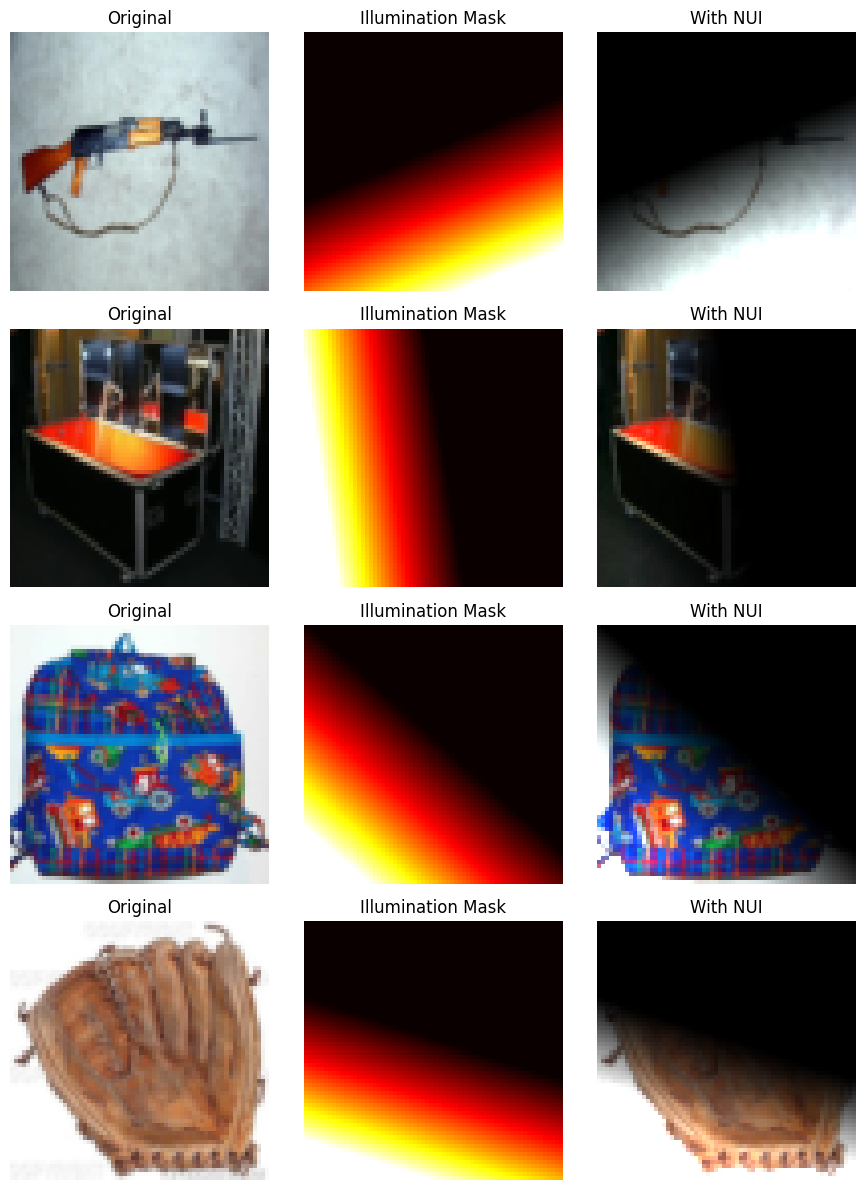

In [ ]:

def visualize_nui_effect(num_images=4):
    try:
        sample_loader = DataLoader(testset, batch_size=num_images, shuffle=True, num_workers=0)
        imgs, labels = next(iter(sample_loader))
        
        fig, axes = plt.subplots(num_images, 3, figsize=(9, 3*num_images))
        if num_images == 1:
            axes = axes.reshape(1, -1)
        
        for i in range(num_images):
            img = imgs[i]
            mask = generate_directional_mask(img.shape[1], img.shape[2], strength=3.5, exponent=2.0)
            img_nui = apply_mask_to_tensor(img, mask)
            
            # Clamp values for display
            img_display = torch.clamp(img.permute(1, 2, 0), 0, 1)
            img_nui_display = torch.clamp(img_nui.permute(1, 2, 0), 0, 1)
            
            axes[i, 0].imshow(img_display)
            axes[i, 0].set_title("Original")
            axes[i, 0].axis("off")
            
            axes[i, 1].imshow(mask, cmap="hot", vmin=0, vmax=2)
            axes[i, 1].set_title("Illumination Mask")
            axes[i, 1].axis("off")
            
            axes[i, 2].imshow(img_nui_display)
            axes[i, 2].set_title("With NUI")
            axes[i, 2].axis("off")
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f" Visualization error: {e}")

# Call visualization
print("\nVisualizing NUI Effect...")
visualize_nui_effect()


7 Baseline vs NUI-Augmented Training

In [9]:
criterion = nn.CrossEntropyLoss()

print("\n" + "="*50)
print(" STARTING EXPERIMENT")
print("="*50)

# --- Baseline Model ---
print("\n=== Training Baseline Model (Clean) ===")
model_clean = TinyCNN(num_classes).to(device)
optimizer_clean = optim.Adam(model_clean.parameters(), lr=0.001)
train_model(model_clean, trainloader, optimizer_clean, criterion, epochs=3, apply_nui=False)

# Evaluate baseline
acc_clean_clean = evaluate(model_clean, testloader, apply_nui=False)
acc_clean_nui = evaluate(model_clean, testloader, apply_nui=True)

print(f" Baseline Model - Clean: {acc_clean_clean*100:.2f}% | NUI: {acc_clean_nui*100:.2f}%")

# --- NUI-Augmented Model ---
print("\n=== Training Robust Model (NUI-Augmented) ===")
model_nui = TinyCNN(num_classes).to(device)
optimizer_nui = optim.Adam(model_nui.parameters(), lr=0.001)
train_model(model_nui, trainloader, optimizer_nui, criterion, epochs=3, apply_nui=True)

# Evaluate robust model
acc_nui_clean = evaluate(model_nui, testloader, apply_nui=False)
acc_nui_nui = evaluate(model_nui, testloader, apply_nui=True)

print(f"Robust Model - Clean: {acc_nui_clean*100:.2f}% | NUI: {acc_nui_nui*100:.2f}%")



 STARTING EXPERIMENT

=== Training Baseline Model (Clean) ===


 Epoch 1: Avg Loss = 2.0655


 Epoch 2: Avg Loss = 1.5111


 Epoch 3: Avg Loss = 1.4231
 Baseline Model - Clean: 57.50% | NUI: 24.00%

=== Training Robust Model (NUI-Augmented) ===


 Epoch 1: Avg Loss = 2.4189


 Epoch 2: Avg Loss = 1.9357


 Epoch 3: Avg Loss = 1.8449
Robust Model - Clean: 39.00% | NUI: 36.00%


## Results Summary

In [10]:

print("\n" + "="*50)
print(" FINAL RESULTS (Caltech-256 Subset)")
print("="*50)

print(f"\n Baseline Model (Trained on Clean Data):")
print(f"   Clean Test Accuracy: {acc_clean_clean*100:.2f}%")
print(f"   NUI Test Accuracy:   {acc_clean_nui*100:.2f}%")
print(f"   Accuracy Drop:       {abs(acc_clean_clean - acc_clean_nui)*100:.2f}%")

print(f"\n Robust Model (NUI-Augmented Training):")
print(f"   Clean Test Accuracy: {acc_nui_clean*100:.2f}%")
print(f"   NUI Test Accuracy:   {acc_nui_nui*100:.2f}%")
print(f"   Accuracy Drop:       {abs(acc_nui_clean - acc_nui_nui)*100:.2f}%")

print(f"\n Improvement Summary:")
drop_before = abs(acc_clean_clean - acc_clean_nui)*100
drop_after = abs(acc_nui_clean - acc_nui_nui)*100
improvement = drop_before - drop_after
print(f"   NUI Robustness Improvement: {improvement:.2f}%")

if improvement > 0:
    print("   NUI-Augmented training successfully improved robustness!")
else:
    print("    No significant improvement detected.")


 FINAL RESULTS (Caltech-256 Subset)

 Baseline Model (Trained on Clean Data):
   Clean Test Accuracy: 57.50%
   NUI Test Accuracy:   24.00%
   Accuracy Drop:       33.50%

 Robust Model (NUI-Augmented Training):
   Clean Test Accuracy: 39.00%
   NUI Test Accuracy:   36.00%
   Accuracy Drop:       3.00%

 Improvement Summary:
   NUI Robustness Improvement: 30.50%
   NUI-Augmented training successfully improved robustness!
